# Segmenting X-Ray Images using Neural Networks

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from keras.models import load_model
from imgaug import augmenters as iaa
from imgaug import parameters as iap

Using TensorFlow backend.


## Load data

In [2]:
hdf5_path = "./aug200.hdf5"
dataset = h5py.File(hdf5_path , 'r')
#print ('loaded')
train_images = dataset['train_img'][:]
no_images, height, width, channels = train_images.shape
#print ('loaded train')
classes = 3

train_labels = dataset['train_label'][:].reshape(-1,height*width, classes)

test_images = dataset['test_img'][:]
test_labels =dataset['test_label'][:].reshape(-1,height*width, classes )
#print ('loaded test')
val_images = dataset['val_img'][:]
val_labels = dataset['val_label'][:].reshape(-1,height*width, classes )
#print ('loaded val')
dataset.close()

## Training data

In [3]:
def training_sample(train_images):
    fig, axs = plt.subplots(2, 5, figsize=(18, 8))
    axs[0,0].imshow(train_images[0].reshape(200,200))
    axs[1,0].imshow(np.argmax(train_labels[0].reshape(200,200,3), axis = 2))
    axs[0,1].imshow(train_images[1].reshape(200,200))
    axs[1,1].imshow(np.argmax(train_labels[1].reshape(200,200,3), axis = 2))
    axs[0,2].imshow(train_images[2].reshape(200,200))
    axs[1,2].imshow(np.argmax(train_labels[2].reshape(200,200,3), axis = 2))
    axs[0,3].imshow(train_images[3].reshape(200,200))
    axs[1,3].imshow(np.argmax(train_labels[3].reshape(200,200,3), axis = 2))
    axs[0,4].imshow(train_images[4].reshape(200,200))
    axs[1,4].imshow(np.argmax(train_labels[4].reshape(200,200,3), axis = 2))
    plt.show()

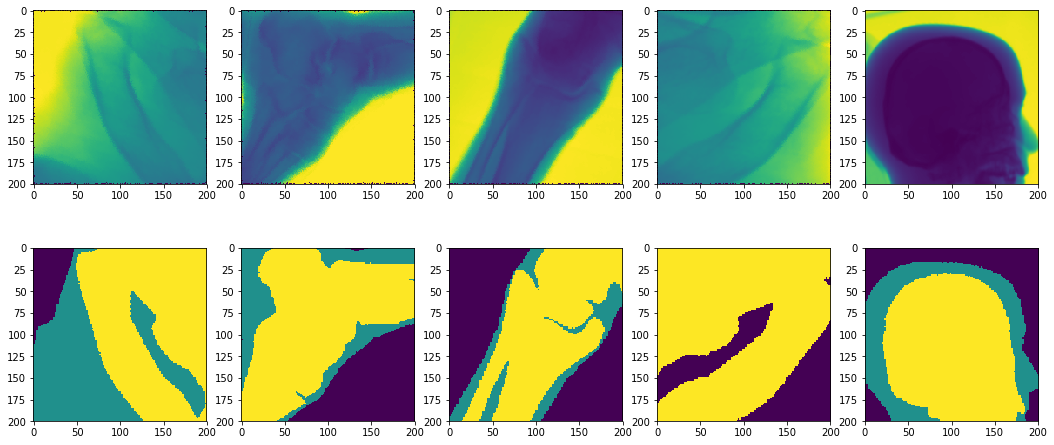

In [4]:
training_sample(train_images)

## Augment Data

In [5]:
def augmentor(image, label):
        " This function defines the trainsformations to apply on the images, and if required on the labels"

        translate_max = 0.01
        rotate_max = 15
        shear_max = 2

        affine_trasform = iaa.Affine( translate_percent={"x": (-translate_max, translate_max),
                                                         "y": (-translate_max, translate_max)}, # translate by +-
                                      rotate=(-rotate_max, rotate_max), # rotate by -rotate_max to +rotate_max degrees
                                      shear=(-shear_max, shear_max), # shear by -shear_max to +shear_max degrees
                                      order=[1], # use nearest neighbour or bilinear interpolation (fast)
                                      cval=125, # if mode is constant, use a cval between 0 and 255
                                      mode="reflect",
                                      #mode = "",
                                      name="Affine",
                                     )


        spatial_aug = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), affine_trasform])

        other_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 0.4)), # blur images with a sigma between 0 and 1.0
                        iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25), # very few

                    ]),

                ])
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        
        elastic_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        sometimes(iaa.ElasticTransformation(alpha=(50, 60), sigma=16)), 
                        # move pixels locally around (with random strengths)
                    ]),
        
                ])

        augmentator = [spatial_aug,other_aug,elastic_aug]
        spatial_det = augmentator[0].to_deterministic() 
        other_det = augmentator[1]
        elastic_aug = augmentator[2]

        image_aug = spatial_det.augment_image(image)
        label_aug = spatial_det.augment_image(label)
        #img_crop, label_crop = random_crop(image_aug,label_aug,0.1,0.4)
        image_aug = other_det.augment_image(image_aug)               
        #label_aug = to_categorical(np.argmax(label_crop,axis=-1), num_classes = self.classes)
        image_aug = elastic_aug.augment_image(image_aug)
        label_aug = elastic_aug.augment_image(label_aug)
        return image_aug, label_aug

In [53]:
image_index = 11

In [7]:
def augment(image_index, train_images):
    fig, axs = plt.subplots(1, 4, figsize=(18, 8))
    im_aug_1, lab_aug = augmentor(train_images[image_index].reshape(200,200), train_labels[image_index].reshape(200,200,3))
    axs[0].imshow(im_aug_1)
    im_aug_2, lab_aug = augmentor(train_images[image_index].reshape(200,200), train_labels[image_index].reshape(200,200,3))
    axs[1].imshow(im_aug_2)
    im_aug_3, lab_aug = augmentor(train_images[image_index].reshape(200,200), train_labels[image_index].reshape(200,200,3))
    axs[2].imshow(im_aug_3)
    im_aug_4, lab_aug = augmentor(train_images[image_index].reshape(200,200), train_labels[image_index].reshape(200,200,3))
    axs[3].imshow(im_aug_4)
    plt.show()

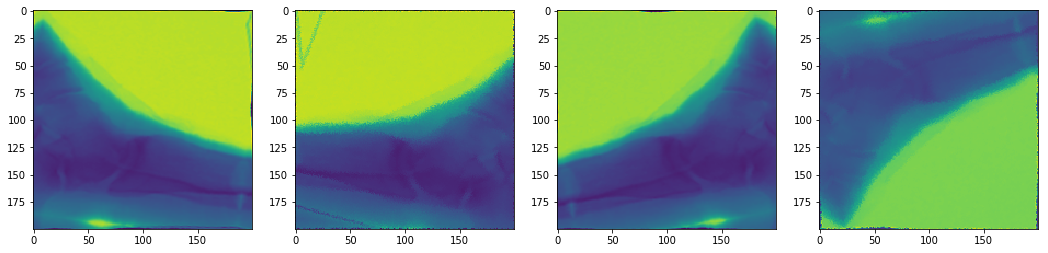

In [54]:
augment(image_index, train_images)

## Load model

In [9]:
model = load_model('DLs200_64.h5')

## Test

In [55]:
test_index = 15

In [11]:
def show_test(test_index, test_images):
    test = test_images[test_index]
    test = test.reshape(200,200)
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(test)
    plt.show()

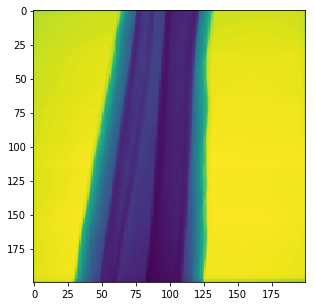

In [56]:
show_test(test_index, test_images)

### Predict

In [13]:
def predict(test_index, test_images, model):
    testing_image = test_images[test_index]
    testing_image = testing_image.reshape((1,200,200,1))
    prediction = model.predict(testing_image)
    prediction = prediction.reshape((200,200,3))
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(prediction)
    plt.show()

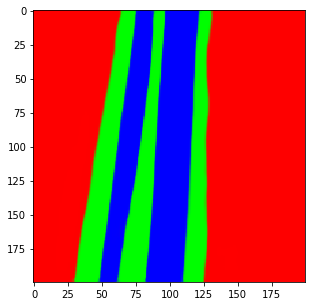

In [57]:
predict(test_index, test_images, model)

### Argmax

In [15]:
def argmax(test_index, test_images, model, test_labels):
    testing_image = test_images[test_index]
    testing_image = testing_image.reshape((1,200,200,1))
    prediction = model.predict(testing_image)
    prediction = prediction.reshape((200,200,3))
    
    prediction_arg = np.argmax(prediction, axis = 2)
    prediction_label = np.argmax(test_labels[test_index].reshape(200,200,3), axis = 2)
    fig, axs = plt.subplots(1, 2, figsize=(8, 18))
    axs[0].imshow(prediction_arg)
    axs[0].set_title('Prediction')
    axs[1].imshow(prediction_label)
    axs[1].set_title('Ground Truth')
    plt.show()

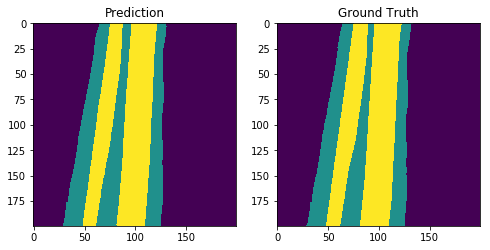

In [58]:
argmax(test_index, test_images, model, test_labels)